In [1]:
# import libraries
library(tidyverse)
library(caret)
library(corrplot)
library(reshape2)
library(gridExtra)
library(leaps)
library('ggpubr')

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.3     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Warning message:
"package 'caret' was built under R version 4.3.2"
Loading required package: lattice


Attaching package: 'caret'


The following object is masked from 'package:purrr':

    lift


Warning message:
"package 'corrplot' was built under R version 4.3.3"
corrplot 0.92 loaded

Warning message:
"package 'reshape2' was built under R version 4.3.2"

Attaching package: 'reshape2'


The following object is masked from 'package:tidyr':

    smiths



Attaching packag

In [2]:
# read in dataset
# from https://www.kaggle.com/datasets/wduckett/moneyball-mlb-stats-19622012
df <- read_csv('data/baseball.csv')

Rows: 1232 Columns: 15
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): Team, League
dbl (13): Year, RS, RA, W, OBP, SLG, BA, Playoffs, RankSeason, RankPlayoffs,...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [3]:
head(df)
dim(df)

Team,League,Year,RS,RA,W,OBP,SLG,BA,Playoffs,RankSeason,RankPlayoffs,G,OOBP,OSLG
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ARI,NL,2012,734,688,81,0.328,0.418,0.259,0,NA,NA,162,0.317,0.415
ATL,NL,2012,700,600,94,0.320,0.389,0.247,1,4,5,162,0.306,0.378
BAL,AL,2012,712,705,93,0.311,0.417,0.247,1,5,4,162,0.315,0.403
BOS,AL,2012,734,806,69,0.315,0.415,0.260,0,NA,NA,162,0.331,0.428
CHC,NL,2012,613,759,61,0.302,0.378,0.240,0,NA,NA,162,0.335,0.424
CHW,AL,2012,748,676,85,0.318,0.422,0.255,0,NA,NA,162,0.319,0.405


[1] 1232   15

In [4]:
# get the number of null values per column
col_na <- data.frame(Nulls = sapply(df, function(x) sum(length(which(is.na(x))))))
col_na

,Nulls
,<int>
Team,0
League,0
Year,0
RS,0
RA,0
W,0
OBP,0
SLG,0
BA,0


In [5]:
# find which years OOBP and OSLG are null
break_na <- count(df[which(is.na(df['OOBP'])),], Year)
break_na

Year,n
<dbl>,<int>
1962,20
1963,20
1964,20
1965,20
1966,20
1967,20
1968,20
1969,24
1970,24


In [6]:
# summarize break_na
summary(break_na)
season_break <- max(break_na)
season_break

      Year            n        
 Min.   :1962   Min.   :20.00  
 1st Qu.:1970   1st Qu.:24.00  
 Median :1979   Median :26.00  
 Mean   :1979   Mean   :24.61  
 3rd Qu.:1988   3rd Qu.:26.00  
 Max.   :1998   Max.   :30.00  

[1] 1998

In [7]:
# create new dataframe to perform cleaning on
df_cleaned <- df

In [8]:
# create champion column
df_cleaned$Champion <- df_cleaned$RankSeason %>% replace_na(0)
df_cleaned$Champion[df_cleaned$Champion > 1] <- 0

In [9]:
# create win percentage column
df_cleaned$WP <- with(df_cleaned, W/G)
# create run differential column
df_cleaned$RD <- with(df_cleaned, RS - RA)
# encode League column
df_cleaned$League <- as.factor(df_cleaned$League)

In [10]:
# drop columns
df_cleaned <- df_cleaned %>% select(-c(Team, RS, RA, W, RankSeason, RankPlayoffs, G))
# rearrange columns
df_cleaned <- df_cleaned %>%
    relocate(Year, League, OBP, SLG, BA, WP, RD, OOBP, OSLG, Playoffs, Champion)

In [11]:
head(df_cleaned)
dim(df_cleaned)

Year,League,OBP,SLG,BA,WP,RD,OOBP,OSLG,Playoffs,Champion
<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2012,NL,0.328,0.418,0.259,0.5000000,46,0.317,0.415,0,0
2012,NL,0.320,0.389,0.247,0.5802469,100,0.306,0.378,1,0
2012,AL,0.311,0.417,0.247,0.5740741,7,0.315,0.403,1,0
2012,AL,0.315,0.415,0.260,0.4259259,-72,0.331,0.428,0,0
2012,NL,0.302,0.378,0.240,0.3765432,-146,0.335,0.424,0,0
2012,AL,0.318,0.422,0.255,0.5246914,72,0.319,0.405,0,0


[1] 1232   11

In [12]:
# full dataset (i.e. drop OOBP and OSLG)
df_full <- df_cleaned %>% select(-c(OOBP, OSLG))

In [13]:
head(df_full)
dim(df_full)

Year,League,OBP,SLG,BA,WP,RD,Playoffs,Champion
<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2012,NL,0.328,0.418,0.259,0.5000000,46,0,0
2012,NL,0.320,0.389,0.247,0.5802469,100,1,0
2012,AL,0.311,0.417,0.247,0.5740741,7,1,0
2012,AL,0.315,0.415,0.260,0.4259259,-72,0,0
2012,NL,0.302,0.378,0.240,0.3765432,-146,0,0
2012,AL,0.318,0.422,0.255,0.5246914,72,0,0


[1] 1232    9

In [14]:
# recent dataset (i.e. retain OOBP and OSLG)
df_recent <- df_cleaned[df_cleaned$Year > season_break, ]

Year,League,OBP,SLG,BA,WP,RD,OOBP,OSLG,Playoffs,Champion
<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2012,NL,0.328,0.418,0.259,0.5000000,46,0.317,0.415,0,0
2012,NL,0.320,0.389,0.247,0.5802469,100,0.306,0.378,1,0
2012,AL,0.311,0.417,0.247,0.5740741,7,0.315,0.403,1,0
2012,AL,0.315,0.415,0.260,0.4259259,-72,0.331,0.428,0,0
2012,NL,0.302,0.378,0.240,0.3765432,-146,0.335,0.424,0,0
2012,AL,0.318,0.422,0.255,0.5246914,72,0.319,0.405,0,0


[1] 420  11

In [ ]:
head(df_recent)
dim(df_recent)

# GLM

In [15]:
# full dataset for modeling
df_full_playoffs <- df_full %>% select(-c(Year, League, Champion))
df_full_champion <- df_full %>% select(-c(Year, League, Playoffs))
# recent dataset for modeling
df_recent_playoffs <- df_recent %>% select(-c(Year, League, Champion))
df_recent_champion <- df_recent %>% select(-c(Year, League, Playoffs))

In [16]:
# train/test split for full data
set.seed(42)
n = floor(0.8 * nrow(df_full)) #find the number corresponding to 80% of the data
index = sample(seq_len(nrow(df_full)), size = n) #randomly sample indicies to be included in the training set
# playoffs
train_full_playoffs = df_full_playoffs[index, ] #set the training set to be the randomly sampled rows of the dataframe
test_full_playoffs = df_full_playoffs[-index, ] #set the testing set to be the remaining rows
# champions
train_full_champion = df_full_champion[index, ] #set the training set to be the randomly sampled rows of the dataframe
test_full_champion = df_full_champion[-index, ] #set the testing set to be the remaining rows

In [17]:
# train/test split for recent data
set.seed(42)
n = floor(0.8 * nrow(df_recent)) #find the number corresponding to 80% of the data
index = sample(seq_len(nrow(df_recent)), size = n) #randomly sample indicies to be included in the training set
# playoffs
train_recent_playoffs = df_recent_playoffs[index, ] #set the training set to be the randomly sampled rows of the dataframe
test_recent_playoffs = df_recent_playoffs[-index, ] #set the testing set to be the remaining rows
# champions
train_recent_champion = df_recent_champion[index, ] #set the training set to be the randomly sampled rows of the dataframe
test_recent_champion = df_recent_champion[-index, ] #set the testing set to be the remaining rows

In [18]:
# single calculation mspe function
model_mspe <- function(test_data, response_var, glmod, threshold=0.5) {
    # gather observations respective to response variable
    obs <- test_data[[response_var]]
    # get probabilities given input
    pred_probs <- predict(glmod, test_data, 'response')
    # turn probabilities into values given the threshold (default=0.5)
    pred <- ifelse(pred_probs > 0.5, 1, 0)
    # calculate mean squared prediction error (mspe)
    mspe <- mean((obs - pred)^2)
    return(mspe)
}

In [91]:
# backwards selection to return several important metrics
backwards_glm <- function(train_data, test_data, response_var, threshold=0.5) {
    # full model
    formula <- paste(response_var, '~ .', '')
    glmod_full <- glm(data = train_data, as.formula(formula), family = binomial)
    # pvals
    pvals <- summary(glmod_full)$coefficients[, 4]
    # feature consideration
    features <- names(pvals)
    features <- features[features != '(Intercept)']
    
    # using deviance
    # null deviance - residual deviance, null residual df - residual deviance df
    # null hypothesis: the model is not useful
    # alternative hypothesis: the model is useful
    dev = 1 - pchisq(glmod_full$null.deviance - glmod_full$deviance,
                     glmod_full$df.null - glmod_full$df.residual)
    
    # dataframe
    results_df <- data.frame(t(sapply(pvals, 'c')),
                             AIC=AIC(glmod_full),
                             DevDiffX2 = dev,
                             Ftest = NA,
                             MSPE=model_mspe(test_data=test_data, response_var=response_var, glmod=glmod_full))
    
    # set glmod_full to glmod for following loop
    glmod <- glmod_full
    
    # go until last feature remains
    while (length(features) > 1) {
        # remove value with max pvalue (intercept is removed in case)
        remove_feature <- names(which.max(unlist(pvals)))
        # create text formula for update() function
        formula <- paste('.~.-', remove_feature)
        # update glm with as.formula() function
        glmod <- update(glmod, as.formula(formula))
        # pvals
        pvals <- summary(glmod)$coefficients[, 4]
        dev = 1 - pchisq(glmod$null.deviance - glmod$deviance,
                         glmod$df.null - glmod$df.residual)
        # new row for dataframe
        new_df <- data.frame(t(sapply(pvals, 'c')),
                             AIC=AIC(glmod), 
                             DevDiffX2 = dev,
                             Ftest=anova(glmod_full, glmod, test='Chisq')[2,5],
                             MSPE=model_mspe(test_data=test_data, response_var=response_var, glmod=glmod))
        # update feature consideration
        features <- names(pvals)
        # remove intercept from features to be considered for removal
        features <- na.omit(features[features != '(Intercept)'])
        # update dataframe
        results_df <- bind_rows(results_df, new_df)
    }
    
    # round all numbers, rename intercept column
    results_df <- results_df %>%
        mutate_if(is.numeric, round, digits=3) %>%
        rename(Int. = X.Intercept.)

    # return ending backwards selection dataframe
    return(results_df)
}

In [20]:
# function for making dataframe long with respect to response variable
create_long_df <- function(df, response) {
    df_long <- pivot_longer(df,
                            cols = names(df %>% select(-all_of(response))),
                            names_to = 'feature_names',
                            values_to = 'feature_values')
    return(df_long)
}

In [21]:
# function for plotting GLM results
plot_glm <- function(full_data, train_data, test_data, response_var, subset_type, threshold=0.5) {
    # backwards selection results table
    bs_results <- backwards_glm(train_data=train_data, test_data=test_data, response_var=response_var)
    
    # long df for plotting facets
    df_long <- create_long_df(full_data, response_var)
    
    # facets plot
    facets_plot <- plot_long_facets(df_long, subset_type=subset_type, response=response_var)
    
    # AIC plot
    x <- 1:dim(bs_results)[1]
    AIC_plot <- ggplot(data=bs_results, aes(x=x, y=AIC)) +
        geom_line() +
        geom_point(aes(x=which.min(AIC), y=min(AIC)), color='red', size=3) +
        xlab('Model') +
        theme(aspect.ratio=1)
    
    # MSPE plot
    MSPE_plot <- ggplot(data=bs_results, aes(x=x, y=MSPE)) +
        geom_line() +
        geom_point(aes(x=which.min(MSPE), y=min(MSPE)), color='red', size=3) +
        xlab('Model') +
        theme(aspect.ratio=1)
    
    # combine AIC and MSPE into single plot
    metrics_plot <- ggarrange(AIC_plot, MSPE_plot,
                              labels = c('AIC', 'MSPE'))
    
    # print results
    print(bs_results)
    print(facets_plot)
    print(metrics_plot)
}

  Int.   OBP   SLG    BA WP    RD     AIC DevDiffX2 Ftest  MSPE
1    0 0.267 0.009 0.524  0 0.753 420.491         0    NA 0.077
2    0 0.280 0.009 0.522  0    NA 418.590         0 0.753 0.073
3    0 0.383 0.011    NA  0    NA 417.000         0 0.775 0.073
4    0    NA 0.000    NA  0    NA 415.762         0 0.736 0.073
5    0    NA    NA    NA  0    NA 435.896         0 0.000 0.057


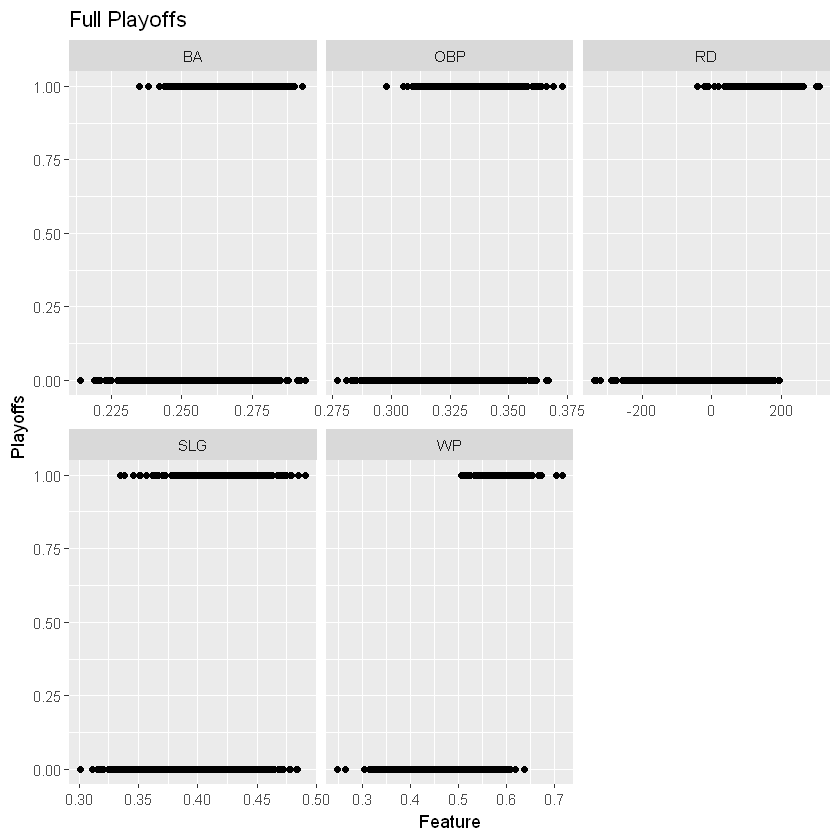

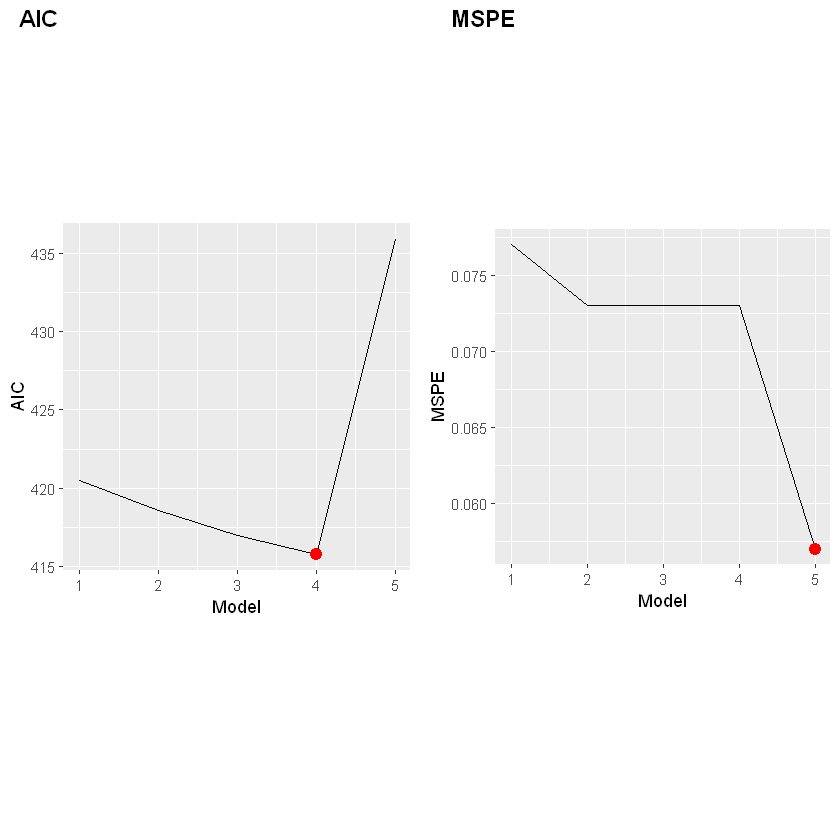

In [92]:
# full dataset - playoffs
plot_glm(df_full_playoffs, train_full_playoffs, test_full_playoffs, 'Playoffs', 'Full')

Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"


  Int.   OBP   SLG    BA WP  RD     AIC DevDiffX2 Ftest  MSPE
1    0 0.340 0.156 0.101  0 0.7 113.492         0    NA 0.036
2    0 0.298 0.162 0.111  0  NA 111.640         0 0.700 0.036
3    0    NA 0.072 0.212  0  NA 110.744         0 0.535 0.036
4    0    NA 0.174    NA  0  NA 110.300         0 0.422 0.032
5    0    NA    NA    NA  0  NA 110.236         0 0.315 0.032


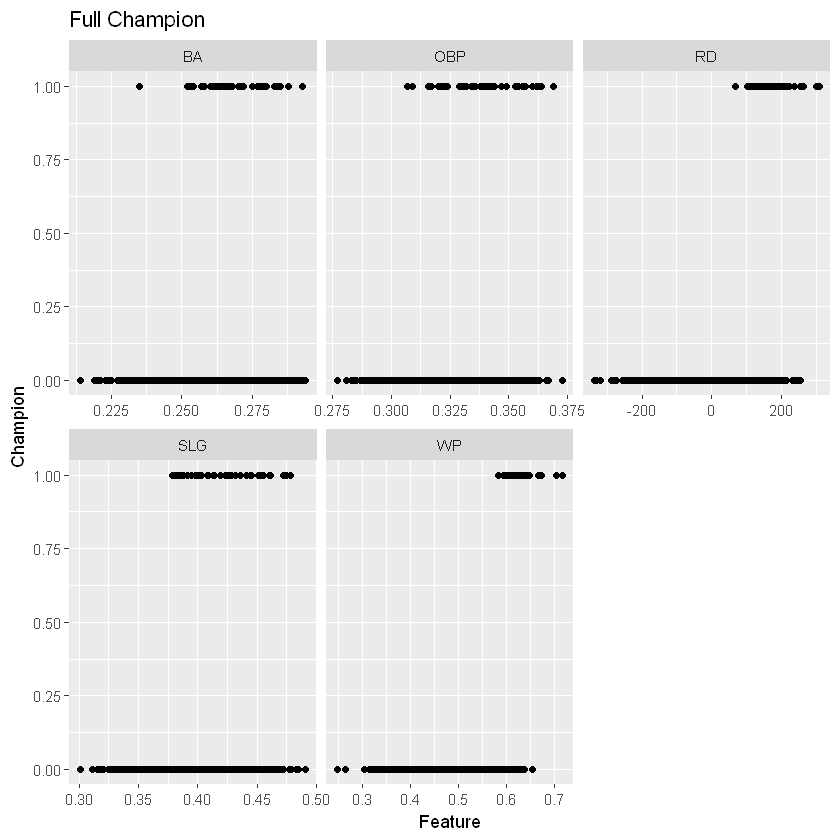

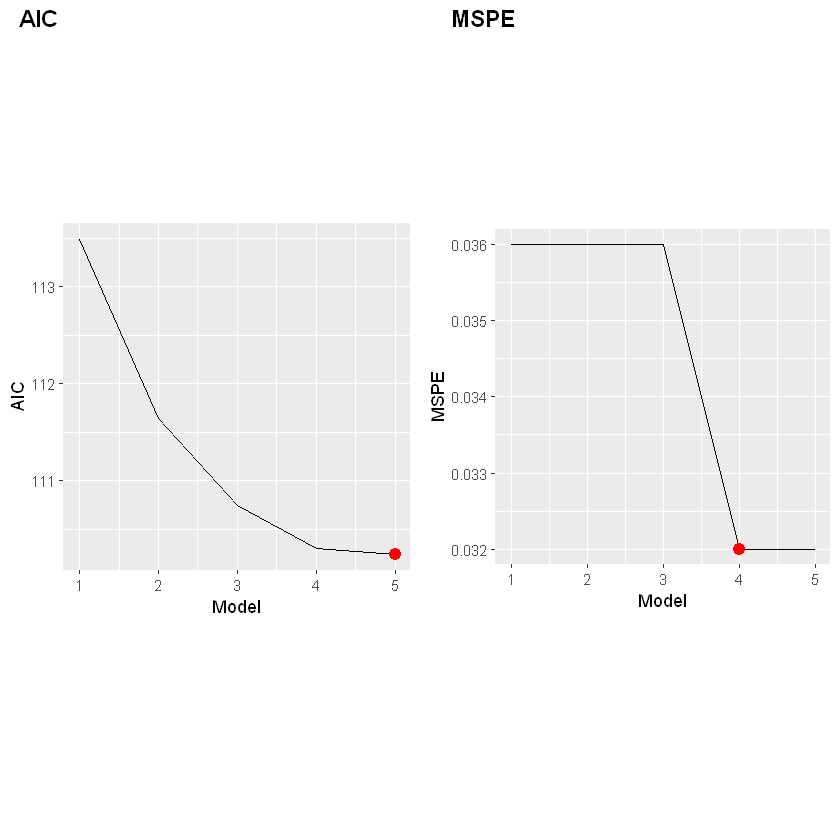

In [93]:
# full dataset - champions
plot_glm(df_full_champion, train_full_champion, test_full_champion, 'Champion', 'Full')

  Int.   OBP   SLG   BA WP    RD  OOBP  OSLG     AIC DevDiffX2 Ftest  MSPE
1    0 0.398 0.208 0.67  0 0.313 0.636 0.608 127.333         0    NA 0.071
2    0 0.465 0.144   NA  0 0.321 0.546 0.639 125.515         0 0.670 0.083
3    0 0.328 0.160   NA  0 0.203 0.462    NA 123.734         0 0.818 0.083
4    0 0.116 0.228   NA  0 0.072    NA    NA 122.279         0 0.814 0.071
5    0 0.290    NA   NA  0 0.069    NA    NA 121.804         0 0.650 0.083
6    0    NA    NA   NA  0 0.115    NA    NA 120.944         0 0.607 0.071
7    0    NA    NA   NA  0    NA    NA    NA 121.513         0 0.403 0.071


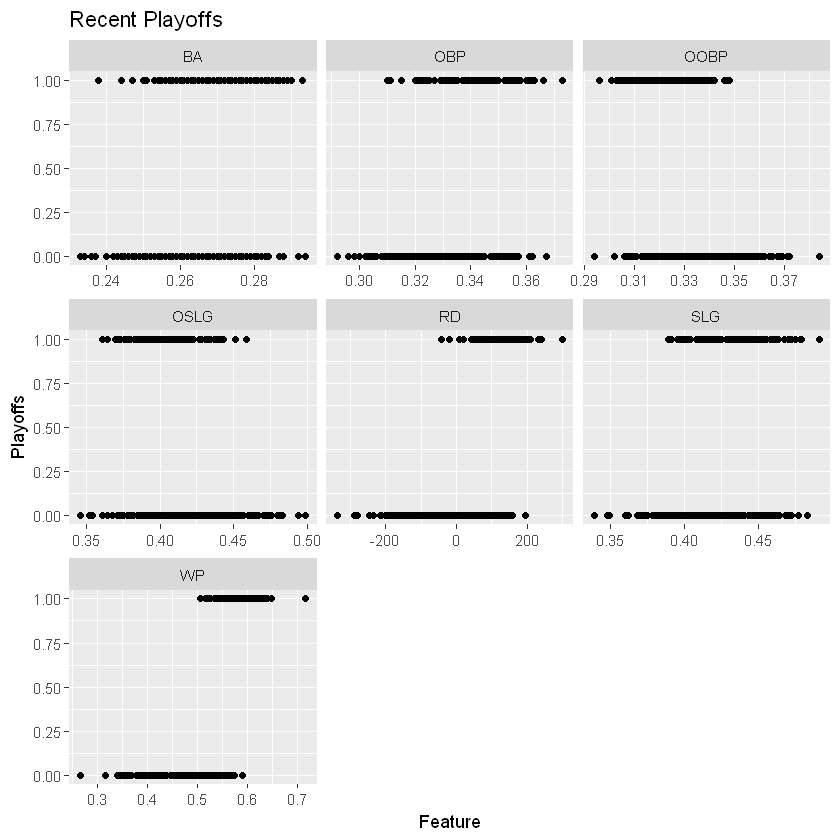

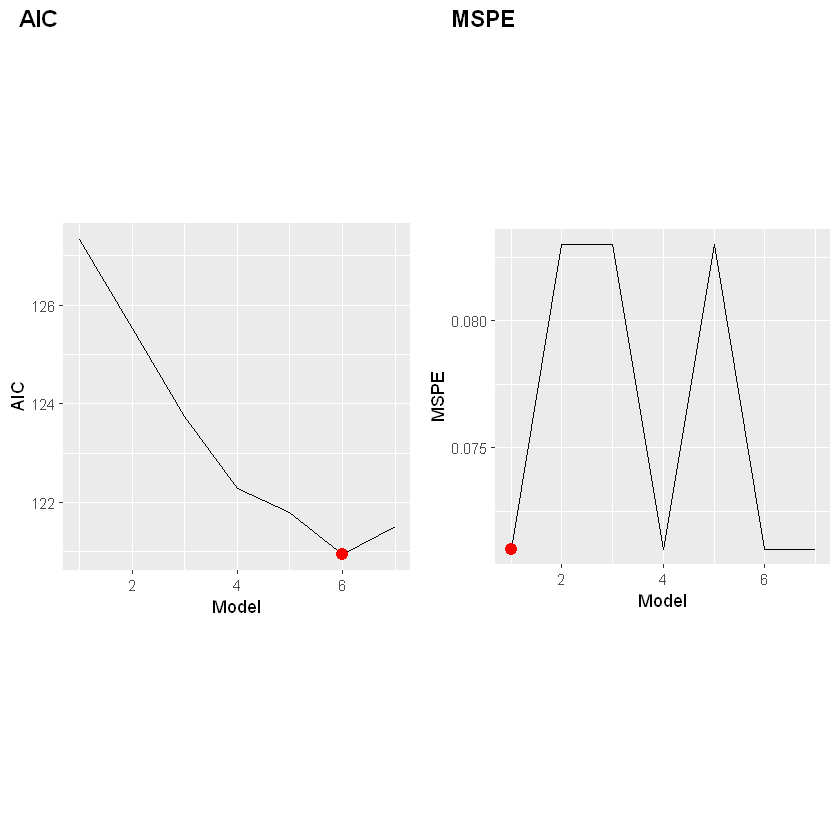

In [94]:
# recent dataset - playoffs
plot_glm(df_recent_playoffs, train_recent_playoffs, test_recent_playoffs, 'Playoffs', 'Recent')

Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"


   Int.   OBP   SLG    BA    WP    RD  OOBP  OSLG    AIC DevDiffX2 Ftest  MSPE
1 0.053 0.614 0.342 0.819 0.001 0.407 0.340 0.430 54.569         0    NA 0.048
2 0.036 0.533 0.219    NA 0.001 0.422 0.341 0.430 52.620         0 0.820 0.048
3 0.039    NA 0.165    NA 0.001 0.553 0.456 0.518 51.014         0 0.800 0.048
4 0.042    NA 0.195    NA 0.001    NA 0.501 0.651 49.372         0 0.849 0.048
5 0.032    NA 0.221    NA 0.000    NA 0.285    NA 47.581         0 0.908 0.048
6 0.000    NA 0.500    NA 0.000    NA    NA    NA 46.751         0 0.823 0.060
7 0.000    NA    NA    NA 0.000    NA    NA    NA 45.208         0 0.853 0.060


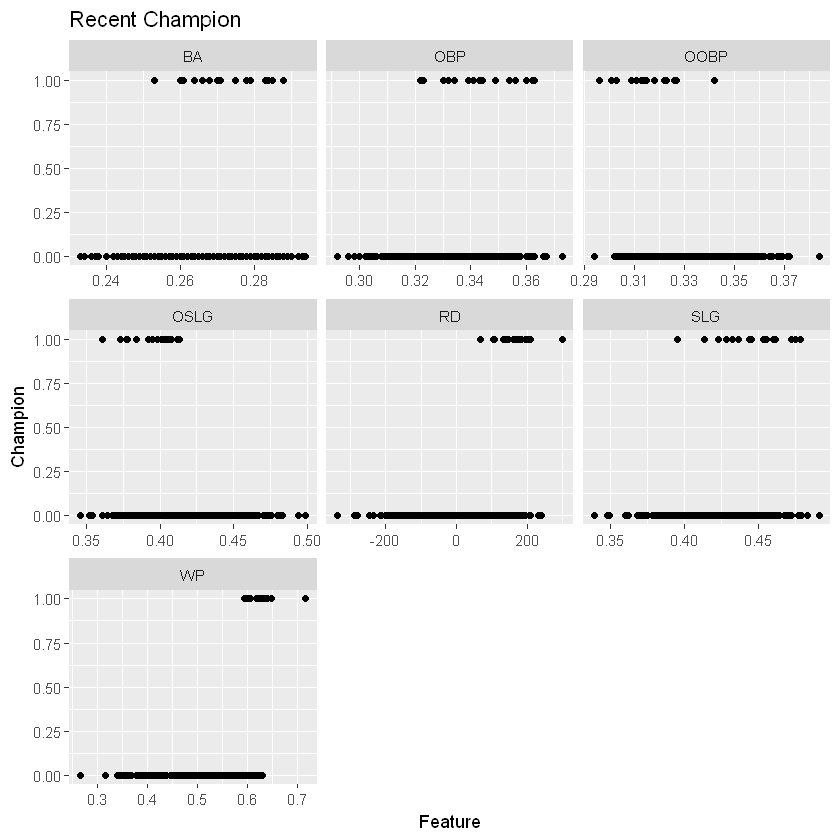

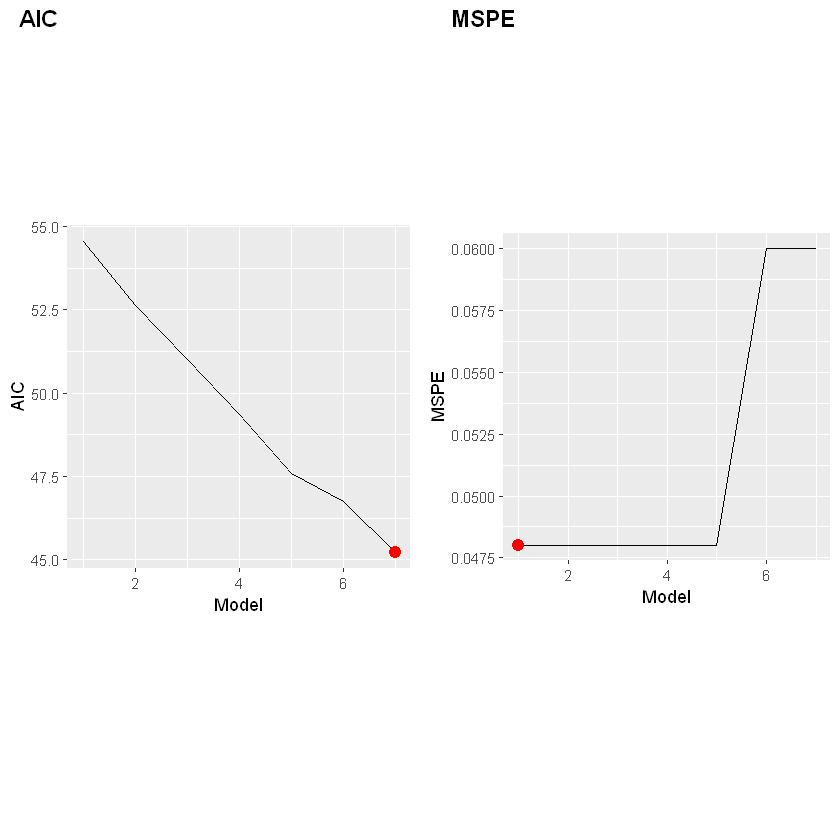

In [95]:
# recent dataset - champion
plot_glm(df_recent_champion, train_recent_champion, test_recent_champion, 'Champion', 'Recent')

1. Elaborate on each of the results.
2. Choose model.
3. Print diagnostics of chosen model and elaborate on that.
4. Compare historic to recent.

# MLR

In [37]:
mspe_loop <- function(train_set, test_set, regsubset_summary, response) {
    # observed values from test set
    obs <- test_set[[response]]
    # initialize mspe tracking list
    mspe_results <- c()
    loop_size <- dim(regsubset_summary$which)[1]
    for (model in 1:loop_size) {
        # create model
        true_cols <- names(which(regsubset_summary$which[model,]))
        # remove intercept feature
        true_cols <- true_cols[true_cols != '(Intercept)']
        formula <- paste(unlist(true_cols), collapse = '+')
        formula <- paste('~', formula, '')
        formula <- paste(response, formula, '')
        lmod <- lm(data = train_set, as.formula(formula))
        # calculate MSPE
        preds <- lmod %>% predict(test_set)
        mspe <- mean((obs - preds)^2)
        mspe_results <- c(mspe_results, mspe)
    }
    return(mspe_results)
}

In [38]:
# function for making dataframe long with respect to response variable
create_long_df <- function(df, response) {
    df_long <- pivot_longer(df,
                            cols = names(df %>% select(-all_of(response))),
                            names_to = 'feature_names',
                            values_to = 'feature_values')
    return(df_long)
}

In [39]:
# create function for faceted plots
plot_long_facets <- function(df_long, subset_type, response) {
    title_text <- paste(subset_type, response)
    ggplot(df_long, aes(x=feature_values, y=!!sym(response))) +
        geom_point() +
        facet_wrap(~ feature_names, scales = 'free_x') +
        ggtitle(title_text) +
        xlab('Feature')
}

In [40]:
# create function to automate the plotting
plot_models <- function(full_set, train_set, test_set, response, subset_type) {
    # faceted plots
    # 1) build long dataframe with respect to variabe
    # 2) create plots
    df_long <- create_long_df(df=full_set, response=response)
    faceted_plots <- plot_long_facets(df_long=df_long, subset_type=subset_type, response=response)
    print(faceted_plots)
    
    # regsubsets builds models with forward selection
    formula <- paste(response, '~.', '')
    reg_lm <- regsubsets(data=train_set, as.formula(formula))
    rs <- summary(reg_lm)
    print(rs$which)
    
    # compute dimensions from dataset
    n <- dim(train_set)[1]
    m <- dim(train_set)[2]
    x <- 1:(m-1)

    # compute metrics
    AIC <- 2*(2:m) + n*log(rs$rss/n)
    BIC <- log(n)*(2:m) + n*log(rs$rss/n)
    R2Adj <- rs$adjr2
    mspe <- mspe_loop(train_set=train_set, test_set=test_set, regsubset_summary=rs, response=response)

    # turn metrics into dataframes
    AIC_df <- data.frame(AIC = AIC)
    BIC_df <- data.frame(BIC = BIC)
    R2Adj_df <- data.frame(R2Adj = R2Adj)
    mspe_df <- data.frame(MSPE = mspe)
    
    # AIC Plot
    AIC_plot <- ggplot(data = AIC_df, aes(x=x, y=AIC)) +
        geom_line() +
        geom_point(aes(x=which.min(AIC), y=min(AIC)), color='red', size=3) +
        xlab('Model')

    # BIC Plot
    BIC_plot <- ggplot(data = BIC_df, aes(x=x, y=BIC)) +
        geom_line() +
        geom_point(aes(x=which.min(BIC), y=min(BIC)), color='red', size=3) +
        xlab('Model')

    # Adjusted R2 Plot
    R2Adj_plot <- ggplot(data = R2Adj_df, aes(x=x, y=R2Adj)) +
        geom_line() +
        geom_point(aes(x=which.max(R2Adj), y=max(R2Adj)), color='red', size=3) +
        xlab('Model')

    # MSPE Plot
    MSPE_plot <- ggplot(data = mspe_df, aes(x=x, y=MSPE)) +
        geom_line() +
        geom_point(aes(x=which.min(mspe), y=min(mspe)), color='red', size=3) +
        xlab('Model')
    
    # combine plots
    combined_plot <- ggarrange(AIC_plot, BIC_plot, R2Adj_plot, MSPE_plot,
                           labels = c('AIC', 'BIC', 'R2Adj', 'MSPE'))
    
    print(combined_plot)
}

In [41]:
# full dataset for modeling
df_full_mlr <- df_full %>% select(-c(Year, League))
# recent dataset for modeling
df_recent_mlr <- df_recent %>% select(-c(Year, League))

In [42]:
# train/test split for full data
set.seed(42)
n = floor(0.8 * nrow(df_full_mlr)) #find the number corresponding to 80% of the data
index = sample(seq_len(nrow(df_full_mlr)), size = n) #randomly sample indicies to be included in the training set
# playoffs
train_full = df_full_mlr[index, ] #set the training set to be the randomly sampled rows of the dataframe
test_full = df_full_mlr[-index, ] #set the testing set to be the remaining rows

In [43]:
# train/test split for recent data
set.seed(42)
n = floor(0.8 * nrow(df_recent_mlr)) #find the number corresponding to 80% of the data
index = sample(seq_len(nrow(df_recent_mlr)), size = n) #randomly sample indicies to be included in the training set
# playoffs
train_recent = df_recent_mlr[index, ] #set the training set to be the randomly sampled rows of the dataframe
test_recent = df_recent_mlr[-index, ] #set the testing set to be the remaining rows

  (Intercept)   OBP   SLG    BA   RD Playoffs Champion
1        TRUE FALSE FALSE FALSE TRUE    FALSE    FALSE
2        TRUE FALSE FALSE FALSE TRUE     TRUE    FALSE
3        TRUE FALSE FALSE FALSE TRUE     TRUE     TRUE
4        TRUE FALSE FALSE  TRUE TRUE     TRUE     TRUE
5        TRUE  TRUE FALSE  TRUE TRUE     TRUE     TRUE
6        TRUE  TRUE  TRUE  TRUE TRUE     TRUE     TRUE


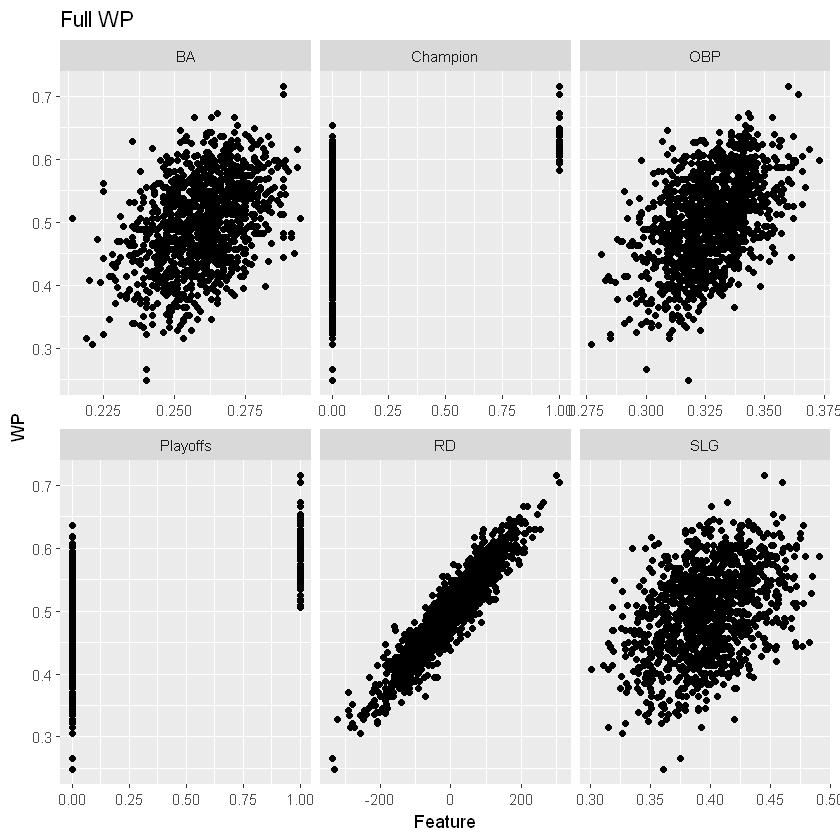

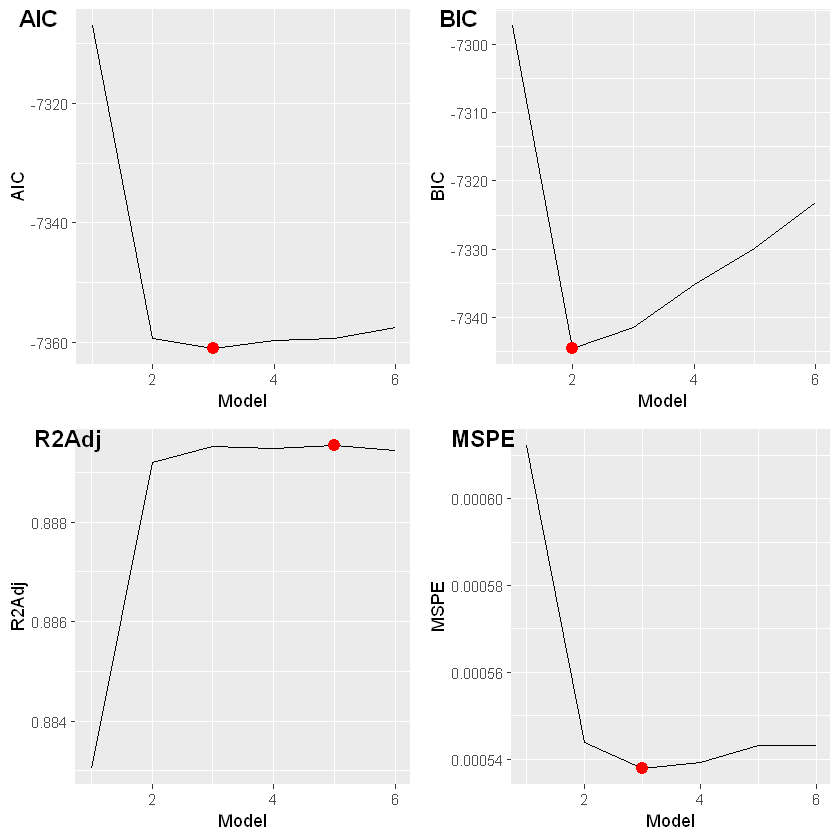

In [96]:
# full data - winning percentage (WP)
# full_set, train_set, test_set, response, subset_type
plot_models(full_set=df_full_mlr, train_set=train_full, test_set=test_full, response='WP', subset_type='Full')

  (Intercept)   SLG   BA    WP    RD Playoffs Champion
1        TRUE FALSE TRUE FALSE FALSE    FALSE    FALSE
2        TRUE  TRUE TRUE FALSE FALSE    FALSE    FALSE
3        TRUE  TRUE TRUE  TRUE FALSE    FALSE    FALSE
4        TRUE  TRUE TRUE  TRUE FALSE    FALSE     TRUE
5        TRUE  TRUE TRUE  TRUE  TRUE    FALSE     TRUE
6        TRUE  TRUE TRUE  TRUE  TRUE     TRUE     TRUE


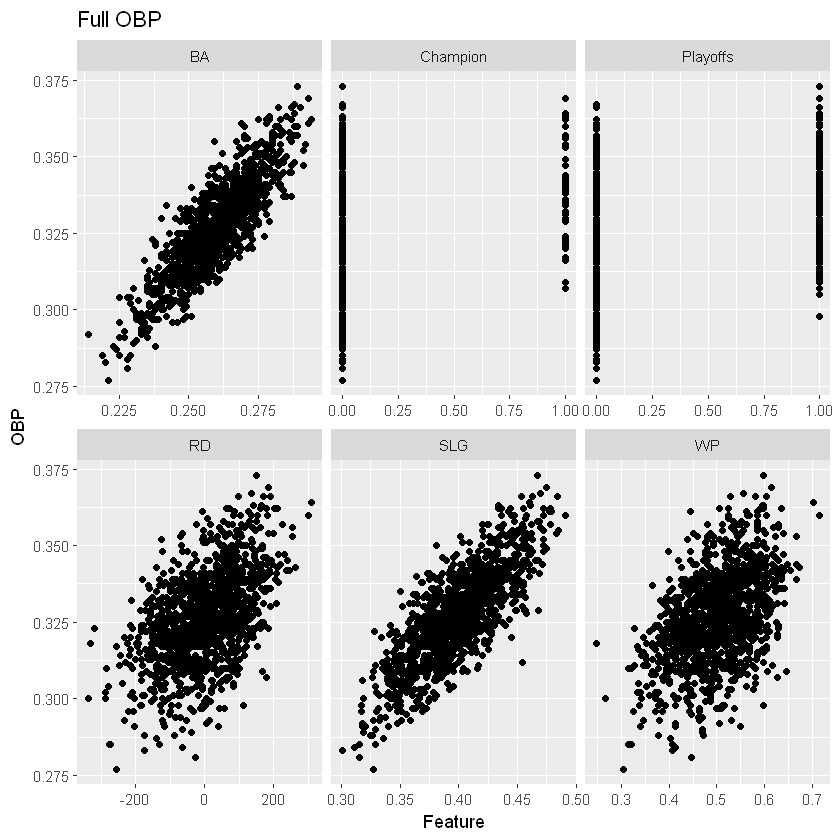

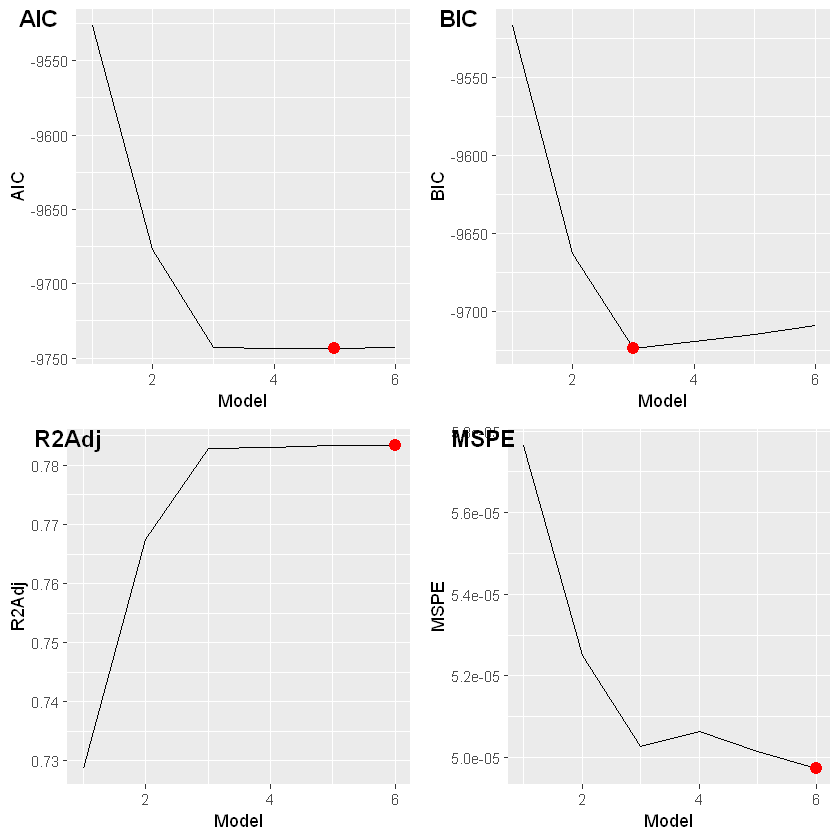

In [45]:
# full data - on-base percentage (OBP)
# full_set, train_set, test_set, response, subset_type
plot_models(full_set=df_full_mlr, train_set=train_full, test_set=test_full, response='OBP', subset_type='Full')

  (Intercept)  OBP    BA    WP    RD Playoffs Champion
1        TRUE TRUE FALSE FALSE FALSE    FALSE    FALSE
2        TRUE TRUE  TRUE FALSE FALSE    FALSE    FALSE
3        TRUE TRUE  TRUE FALSE FALSE     TRUE    FALSE
4        TRUE TRUE  TRUE  TRUE FALSE     TRUE    FALSE
5        TRUE TRUE  TRUE  TRUE FALSE     TRUE     TRUE
6        TRUE TRUE  TRUE  TRUE  TRUE     TRUE     TRUE


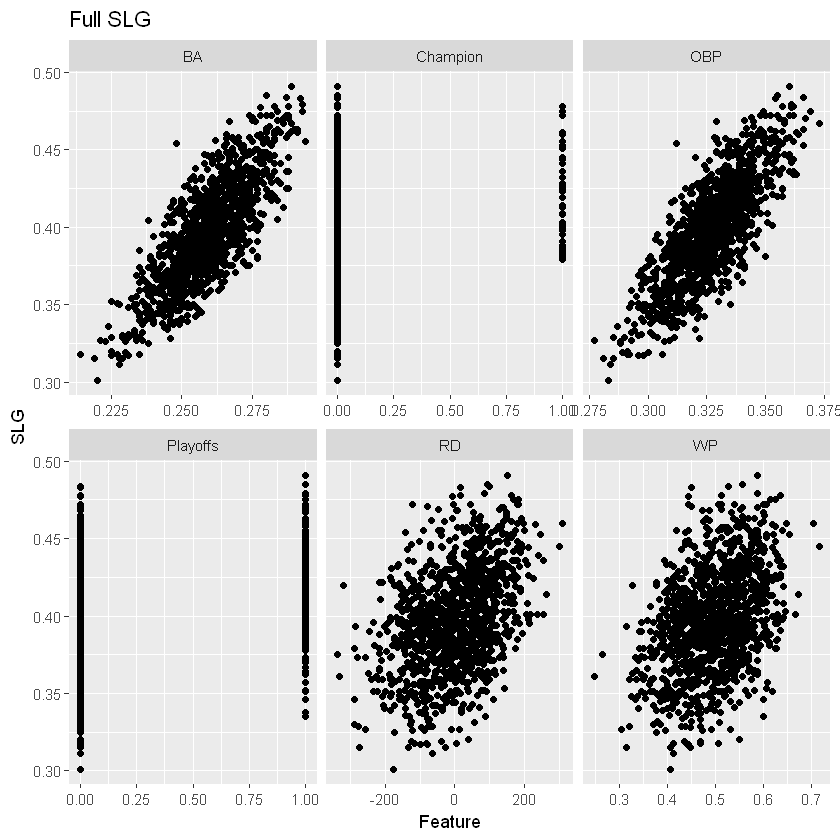

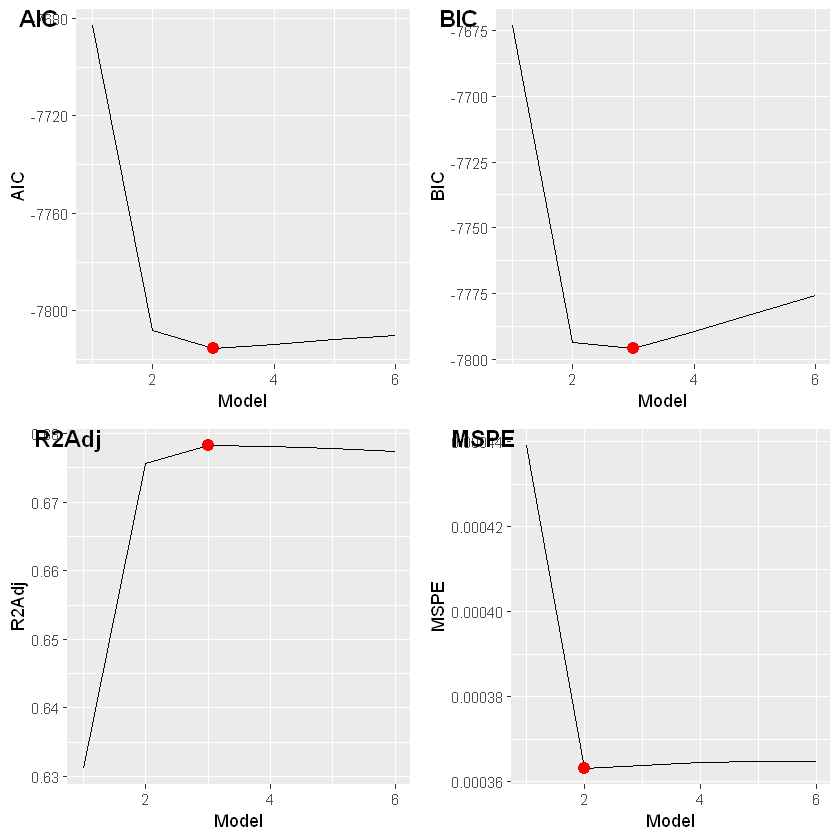

In [46]:
# full data - slugging percentage (SLG)
# full_set, train_set, test_set, response, subset_type
plot_models(full_set=df_full_mlr, train_set=train_full, test_set=test_full, response='SLG', subset_type='Full')

  (Intercept)   OBP   SLG    BA   RD  OOBP  OSLG Playoffs Champion
1        TRUE FALSE FALSE FALSE TRUE FALSE FALSE    FALSE    FALSE
2        TRUE FALSE FALSE FALSE TRUE FALSE FALSE     TRUE    FALSE
3        TRUE FALSE FALSE FALSE TRUE  TRUE FALSE     TRUE    FALSE
4        TRUE FALSE  TRUE FALSE TRUE  TRUE FALSE     TRUE    FALSE
5        TRUE FALSE  TRUE FALSE TRUE  TRUE FALSE     TRUE     TRUE
6        TRUE FALSE  TRUE FALSE TRUE  TRUE  TRUE     TRUE     TRUE
7        TRUE  TRUE  TRUE FALSE TRUE  TRUE  TRUE     TRUE     TRUE
8        TRUE  TRUE  TRUE  TRUE TRUE  TRUE  TRUE     TRUE     TRUE


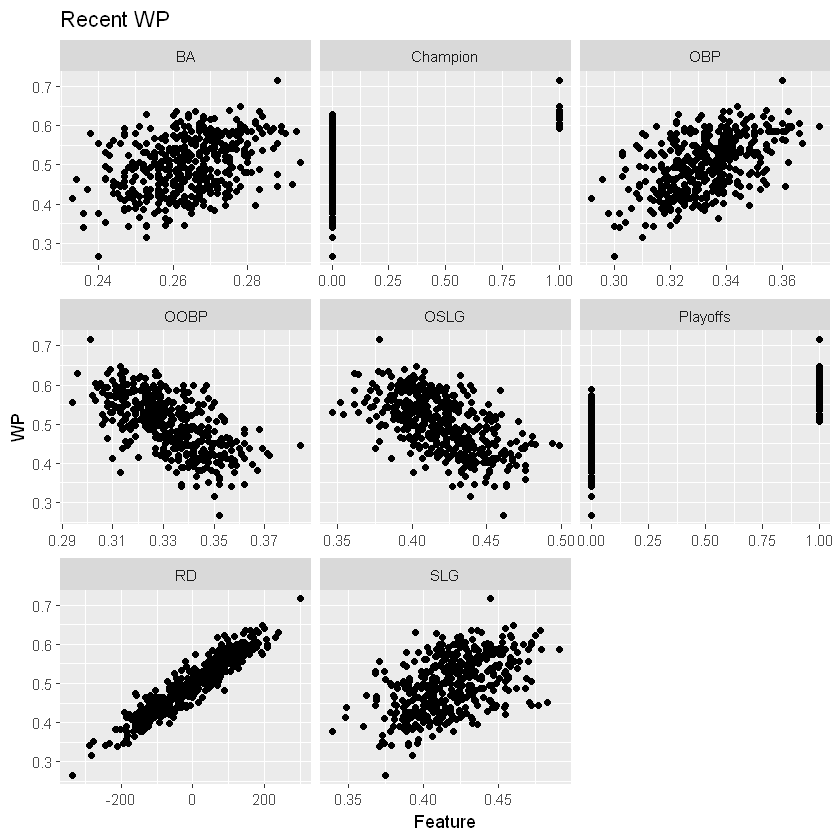

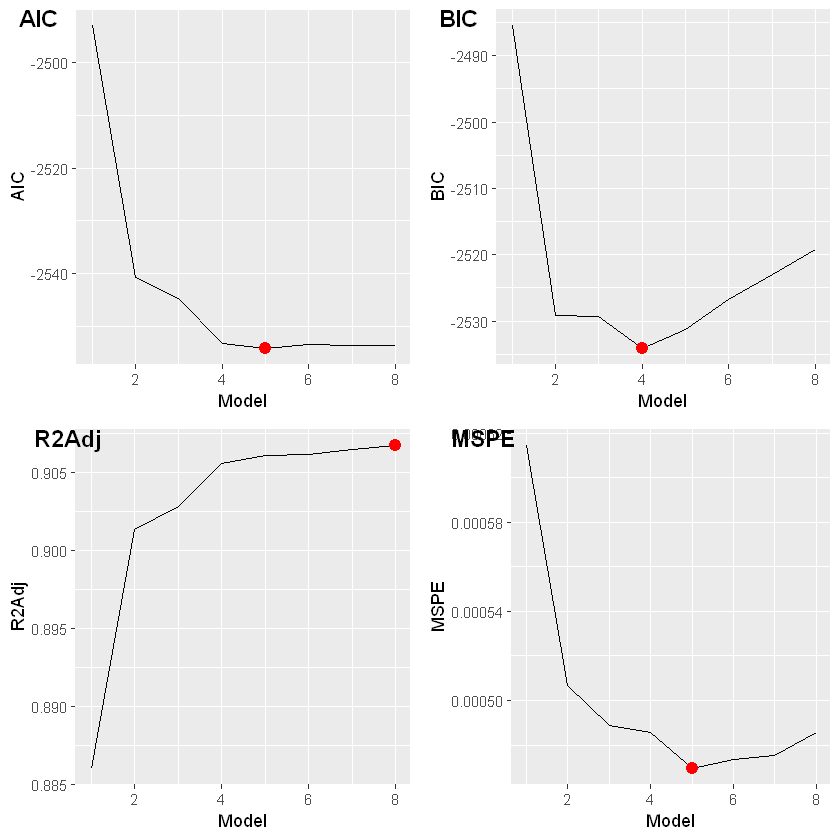

In [47]:
# recent data - winning percentage (WP)
# full_set, train_set, test_set, response, subset_type
plot_models(full_set=df_recent_mlr, train_set=train_recent, test_set=test_recent, response='WP', subset_type='Recent')

  (Intercept)   SLG   BA    WP    RD  OOBP  OSLG Playoffs Champion
1        TRUE FALSE TRUE FALSE FALSE FALSE FALSE    FALSE    FALSE
2        TRUE  TRUE TRUE FALSE FALSE FALSE FALSE    FALSE    FALSE
3        TRUE FALSE TRUE FALSE  TRUE  TRUE FALSE    FALSE    FALSE
4        TRUE FALSE TRUE FALSE  TRUE  TRUE  TRUE    FALSE    FALSE
5        TRUE FALSE TRUE  TRUE  TRUE  TRUE  TRUE    FALSE    FALSE
6        TRUE  TRUE TRUE  TRUE  TRUE  TRUE  TRUE    FALSE    FALSE
7        TRUE  TRUE TRUE  TRUE  TRUE  TRUE  TRUE     TRUE    FALSE
8        TRUE  TRUE TRUE  TRUE  TRUE  TRUE  TRUE     TRUE     TRUE


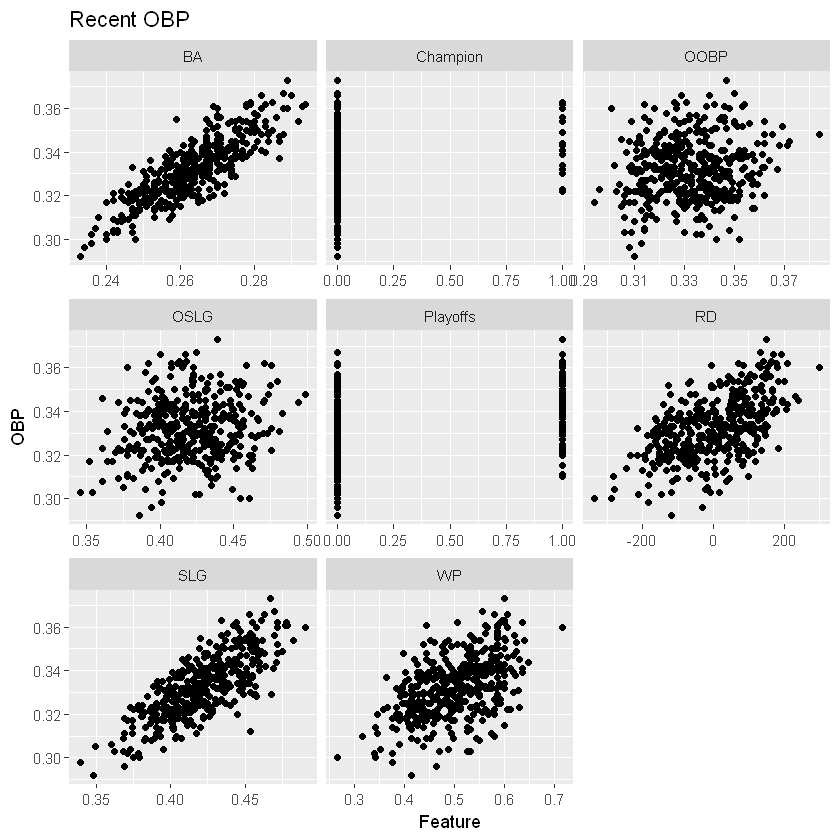

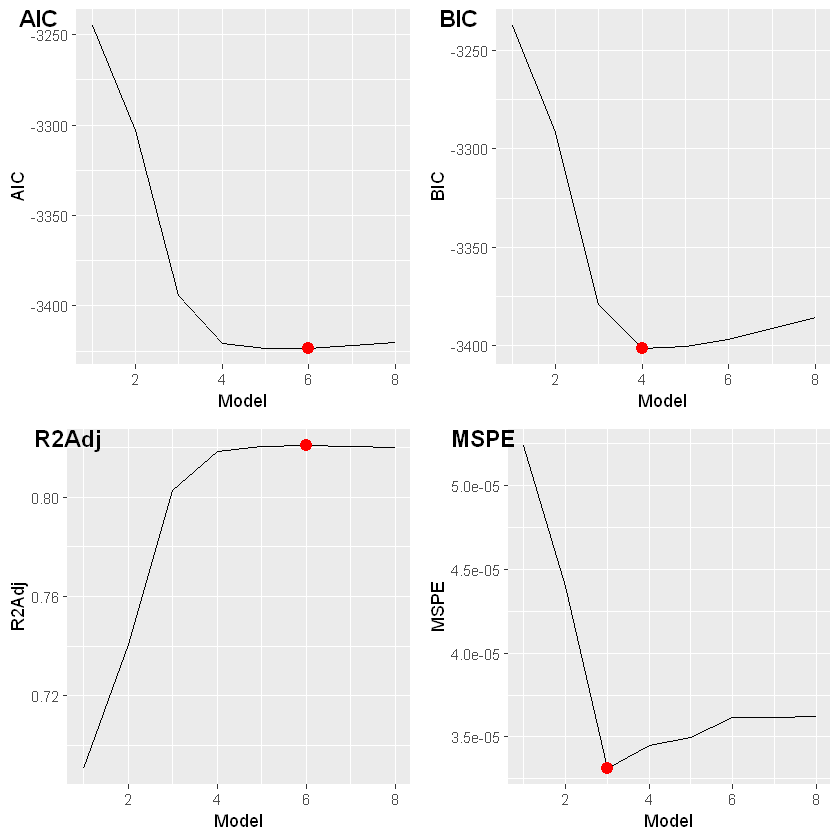

In [48]:
# recent data - on-base percentage (OBP)
# full_set, train_set, test_set, response, subset_type
plot_models(full_set=df_recent_mlr, train_set=train_recent, test_set=test_recent, response='OBP', subset_type='Recent')

  (Intercept)   OBP    BA    WP    RD  OOBP  OSLG Playoffs Champion
1        TRUE  TRUE FALSE FALSE FALSE FALSE FALSE    FALSE    FALSE
2        TRUE FALSE FALSE FALSE  TRUE FALSE  TRUE    FALSE    FALSE
3        TRUE FALSE FALSE FALSE  TRUE  TRUE  TRUE    FALSE    FALSE
4        TRUE FALSE  TRUE FALSE  TRUE  TRUE  TRUE    FALSE    FALSE
5        TRUE FALSE  TRUE  TRUE  TRUE  TRUE  TRUE    FALSE    FALSE
6        TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE    FALSE    FALSE
7        TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE     TRUE    FALSE
8        TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE     TRUE     TRUE


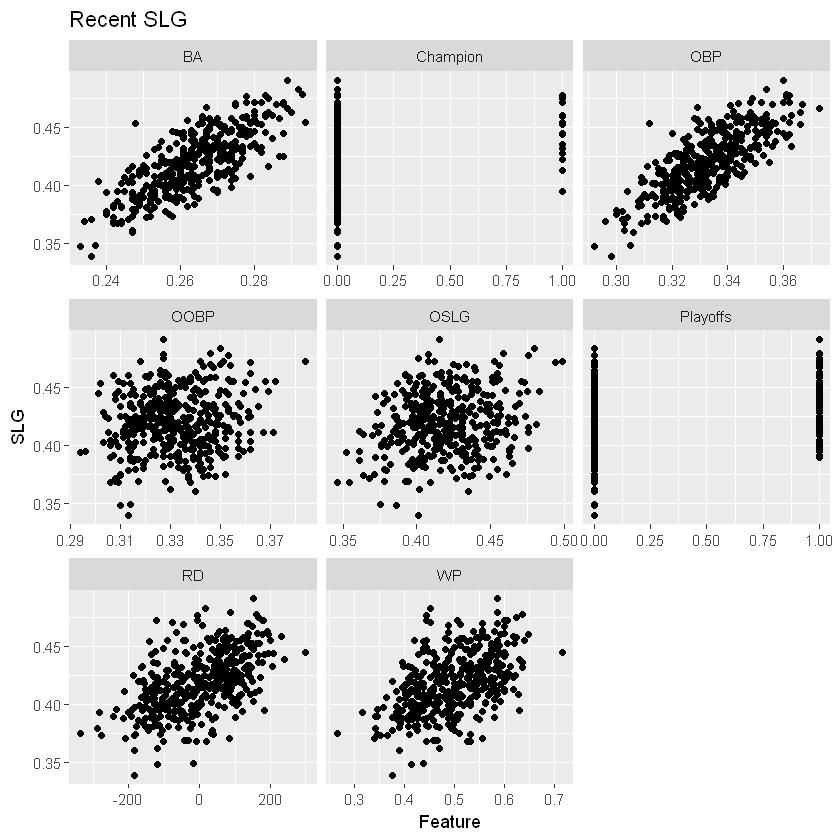

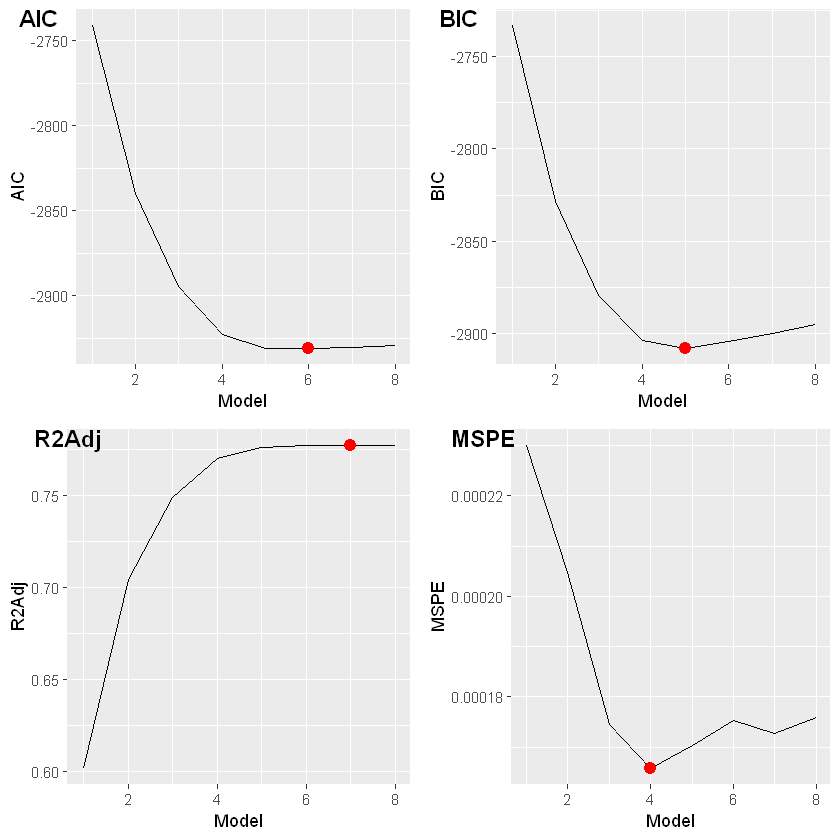

In [49]:
# recent data - slugging percentage (SLG)
# full_set, train_set, test_set, response, subset_type
plot_models(full_set=df_recent_mlr, train_set=train_recent, test_set=test_recent, response='SLG', subset_type='Recent')

1. Elaborate on each of the results.
2. VIF
3. Choose model.
4. Print diagnostics of chosen model and elaborate on that.
5. Compare historic to recent.

# The Pythagorean Theorem of Baseball

Let

$R_s$: Runs Scored

$R_a$: Runs Allowed

$W_p$: Winning Percentage

Then, there were two formulas presented:

The more *common*:

$W_p = \frac{R_s^2}{R_s^2 + R_a^2}$

The more *accurate*:

$W_p = \frac{R_s^{1.81}}{R_s^{1.81} + R_a^{1.81}}$

---

Our goal is to find some factor, $f$, such that:

$$W_p = \frac{R_s^f}{R_s^f + R_a^f}$$

---

For ease, let's assign 

- $R_s = s$
- $R_a = a$
- $W_p = p$

$W_p = \frac{R_s^f}{R_s^f + R_a^f}$

$\rightarrow p = \frac{s^f}{s^f + a^f}$

$(s^f + a^f) p = \frac{s^f}{s^f + a^f} (s^f + a^f)$

$(s^f + a^f)p = s^f$

$s^fp + a^fp = s^f$

$a^fp = s^f - s^fp$

$a^fp = s^f(1 - p)$

$\frac{p}{1 - p} = \frac{s^f}{a^f}$

$\log(\frac{p}{1 - p}) = \log(\frac{s^f}{a^f})$

$\log(\frac{p}{1 - p}) = f\log(\frac{s}{a})$

---

So what this means for our dataset and model is that we can transform our columns into:

- $y = \log(\frac{W_p}{1-W_p})$: response variable
- $x = \log(\frac{R_s}{R_a})$: predictor variable

By using simple linear regression, we can create a model where

$y = \beta_0 + \beta_1 x$,

If the **Pythagorean Formula of Baseball** holds weight, then we would roughly expect

$\beta_0$ to be close to $0$ and $\beta_1$ near the range $(1.81, 2)$, from:

The more *common*:

$W_p = \frac{R_s^2}{R_s^2 + R_a^2}$

The more *accurate*:

$W_p = \frac{R_s^{1.81}}{R_s^{1.81} + R_a^{1.81}}$

In [50]:
# let's begin
# select the necessary columns
df_theorem <- df %>% select(c(RS, RA, W, G))
# create win percentage
df_theorem$WP <- with(df_theorem, W/G)
# drop columns used in the win percentage column
df_theorem <- df_theorem %>% select(-c(W, G))
# create the response column
df_theorem$response <- with(df_theorem, log(WP/(1-WP)))
# create the predictor column
df_theorem$predictor <- with(df_theorem, log(RS/RA))
head(df_theorem)

RS,RA,WP,response,predictor
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
734,688,0.5000000,0.00000000,0.064720191
700,600,0.5802469,0.32378708,0.154150680
712,705,0.5740741,0.29849299,0.009880109
734,806,0.4259259,-0.29849299,-0.093574714
613,759,0.3765432,-0.50424665,-0.213636841
748,676,0.5246914,0.09884583,0.101209902


In [51]:
lmod <- lm(data=df_theorem, response ~ predictor)
summary(lmod)
confint(lmod, 'predictor', level=0.95)


Call:
lm(formula = response ~ predictor, data = df_theorem)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.36456 -0.06840  0.00013  0.06704  0.31094 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.002198   0.002828  -0.777    0.437    
predictor    1.870947   0.019587  95.519   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.09926 on 1230 degrees of freedom
Multiple R-squared:  0.8812,	Adjusted R-squared:  0.8811 
F-statistic:  9124 on 1 and 1230 DF,  p-value: < 2.2e-16


,2.5 %,97.5 %
predictor,1.832519,1.909375


In [52]:
# beta_0 lacks statistical evidence that it is not 0!

1. Comment on results
2. Produce complementary plots
2. Produce diagnostic plots